In [1]:
# Prediction stock returns with linear regression
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from time import time
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [3]:
sns.set_style('darkgrid')
idx = pd.IndexSlice

In [4]:
YEAR = 252

In [5]:
with pd.HDFStore('/Volumes/My Book/Data_Analysis/Data/data.h5') as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))

In [6]:
data.index.names = ['symbol', 'date']

In [7]:
data = data.drop([c for c in data.columns if 'lag' in c], axis=1)

In [8]:
# Select Investment Universe
data = data[data.dollar_vol_rank<100]

In [109]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 109749 entries, ('AAL', Timestamp('2013-07-03 00:00:00')) to ('ZTS', Timestamp('2014-12-10 00:00:00'))
Data columns (total 45 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   volume                  109749 non-null  float64
 1   dollar_vol              109749 non-null  float64
 2   dollar_vol_1m           109749 non-null  float64
 3   dollar_vol_rank         109749 non-null  float64
 4   rsi                     109749 non-null  float64
 5   bb_high                 109749 non-null  float64
 6   bb_low                  109749 non-null  float64
 7   atr                     109749 non-null  float64
 8   macd                    109749 non-null  float64
 9   return_1d               109749 non-null  float64
 10  return_5d               109749 non-null  float64
 11  return_10d              109749 non-null  float64
 12  return_21d              109749 non-null  float64
 13 

In [113]:
# Drop non-required columns
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'consumer_discretionary'], axis=1)

In [114]:
# Custom MultipleTimeSeriesCV
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values('date').unique()
        days = sorted(unique_dates, reverse=True)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])
        dates = X.reset_index()[['date']]
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[(dates.date > days[train_start])
                              & (dates.date <= days[train_end])].index
            test_idx = dates[(dates.date > days[test_start])
                             & (dates.date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [115]:
# Verify that it works
train_period_length = 63
test_period_length = 10
n_splits = int(3 * YEAR/test_period_length)
lookahead =1 

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [116]:
# Split the date for training set and test set. Display train and test periods/ dates.
i = 0
for train_idx, test_idx in cv.split(X=data):
    train = data.iloc[train_idx]
    train_dates = train.index.get_level_values('date')
    test = data.iloc[test_idx]
    test_dates = test.index.get_level_values('date')
    df = pd.concat([train.reset_index(), test.reset_index()])
    n = len(df)
    assert n== len(df.drop_duplicates())
    print(train.groupby(level='symbol').size().value_counts().index[0],
          train_dates.min().date(), train_dates.max().date(),
          test.groupby(level='symbol').size().value_counts().index[0],
          test_dates.min().date(), test_dates.max().date())
    i += 1
    if i == 10:
        break

63 2017-08-16 2017-11-14 10 2017-11-15 2017-11-29
63 2017-08-02 2017-10-30 10 2017-10-31 2017-11-14
63 2017-07-19 2017-10-16 10 2017-10-17 2017-10-30
63 2017-07-05 2017-10-02 10 2017-10-03 2017-10-16
63 2017-06-20 2017-09-18 10 2017-09-19 2017-10-02
63 2017-06-06 2017-09-01 10 2017-09-05 2017-09-18
63 2017-05-22 2017-08-18 10 2017-08-21 2017-09-01
63 2017-05-08 2017-08-04 10 2017-08-07 2017-08-18
63 2017-04-24 2017-07-21 10 2017-07-24 2017-08-04
62 2017-04-10 2017-07-07 10 2017-07-10 2017-07-21


In [14]:
# Visualization helper functions
# Prediction vs Actual Scatter Plot
def plot_preds_scatter(df, ticker=None):
    if ticker is not None:
        idx = pd.IndexSlice
        df = df.loc[idx[ticker, :], :]
    j = sns.jointplot(x='predicted', y='actuals',
                      robust=True, ci=None,
                      line_kws={'lw': 1, 'color': 'k'},
                      scatter_kws={'s': 1},
                      data=df,
                      kind='reg')
    j.ax_joint.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    j.ax_joint.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
    j.ax_joint.set_xlabel('Predicted')
    j.ax_joint.set_ylabel('Actuals')


In [15]:
# Daily IC Distribution
def plot_ic_distribution(df, ax=None):
    if ax is not None:
        sns.distplot(df.ic, ax=ax)
    else:
        ax = sns.distplot(df.ic)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9,
            s=f'Mean: {mean:8.2f}\nMedian: {median:5.2f}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout()

In [16]:
# Rolling Daily IC
def plot_rolling_ic(df):
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(14, 8))
    rolling_result = df.sort_index().rolling(21).mean().dropna()
    mean_ic = df.ic.mean()
    rolling_result.ic.plot(ax=axes[0],
                           title=f'Information Coefficient (Mean: {mean_ic:.2f})',
                           lw=1)
    axes[0].axhline(0, lw=.5, ls='-', color='k')
    axes[0].axhline(mean_ic, lw=1, ls='--', color='k')

    mean_rmse = df.rmse.mean()
    rolling_result.rmse.plot(ax=axes[1],
                             title=f'Root Mean Squared Error (Mean: {mean_rmse:.2%})',
                             lw=1,
                             ylim=(0, df.rmse.max()))
    axes[1].axhline(df.rmse.mean(), lw=1, ls='--', color='k')
    sns.despine()
    plt.tight_layout()

In [17]:
# Linear Regression with sklearn
# Set up cross-validation
train_period_length = 63
test_period_length = 10
n_splits = int(3 * YEAR / test_period_length)
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [118]:
%%time
# Run cross-validation with LinearRegression - with sklearn
target = f'target_{lookahead}d'
lr_predictions, lr_scores = [], []
lr = LinearRegression()
for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
    X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]
    lr.fit(X=X_train, y=y_train)
    y_pred = lr.predict(X_test)
    
    preds = y_test.to_frame('actuals').assign(predicted=y_pred)
    preds_by_day = preds.groupby(level='date')
    scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                               x.actuals)[0] * 100)
                        .to_frame('ic'),
                        preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                y_true=x.actuals)))
                        .to_frame('rmse')], axis=1)

    lr_scores.append(scores)
    lr_predictions.append(preds)

lr_scores = pd.concat(lr_scores)
lr_predictions = pd.concat(lr_predictions)
print(lr_predictions, lr_scores)

                    actuals  predicted
symbol date                           
AAPL   2017-11-15  0.011947  -0.000379
       2017-11-16 -0.005552   0.000405
       2017-11-17 -0.000999  -0.000251
       2017-11-20  0.018590   0.000076
       2017-11-21  0.010512   0.000519
...                     ...        ...
XOM    2014-12-18  0.027205  -0.001282
       2014-12-19 -0.003311  -0.001887
       2014-12-22  0.013500  -0.001830
ZTS    2014-12-09 -0.023962   0.000026
       2014-12-10  0.002572   0.000265

[74030 rows x 2 columns]                    ic      rmse
date                           
2017-11-15   0.454577  0.019423
2017-11-16 -27.794767  0.012235
2017-11-17  21.251650  0.010289
2017-11-20  27.602981  0.012934
2017-11-21 -17.801197  0.008915
...               ...       ...
2014-12-16 -16.528139  0.033659
2014-12-17  34.618429  0.030308
2014-12-18 -42.160792  0.021620
2014-12-19  18.824985  0.019757
2014-12-22 -32.933828  0.016086

[750 rows x 2 columns]
CPU times: user 11.4 s, sys

In [19]:
# Persist results
lr_scores.to_hdf('/Volumes/My Book/Data_Analysis/Data/data.h5', 'lr/scores')
lr_predictions.to_hdf('/Volumes/My Book/Data_Analysis/Data/data.h5', 'lr/predictions')

In [20]:
# Read results
lr_scores = pd.read_hdf('/Volumes/My Book/Data_Analysis/Data/data.h5', 'lr/scores')
lr_predictions = pd.read_hdf('/Volumes/My Book/Data_Analysis/Data/data.h5', 'lr/predictions')

In [21]:
# Evaluate results
lr_r, lr_p = spearmanr(lr_predictions.actuals, lr_predictions.predicted)
print(f'Information Coefficient (overall): {lr_r:.3%} (p-value: {lr_p:.4%})')

Information Coefficient (overall): 1.354% (p-value: 0.0229%)


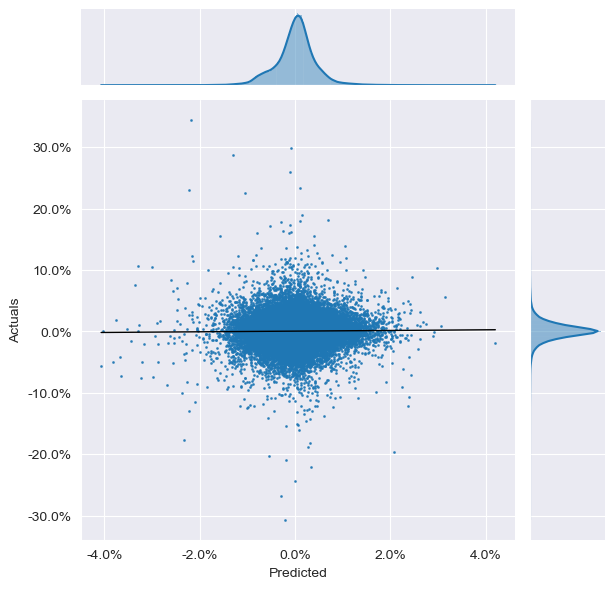

In [22]:
# Prediction vs Actuals Scatter
plot_preds_scatter(lr_predictions)

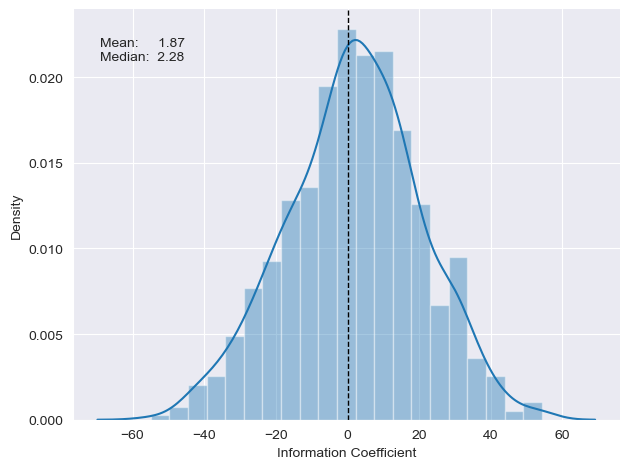

In [23]:
# Daily IC Distribution
plot_ic_distribution(lr_scores)

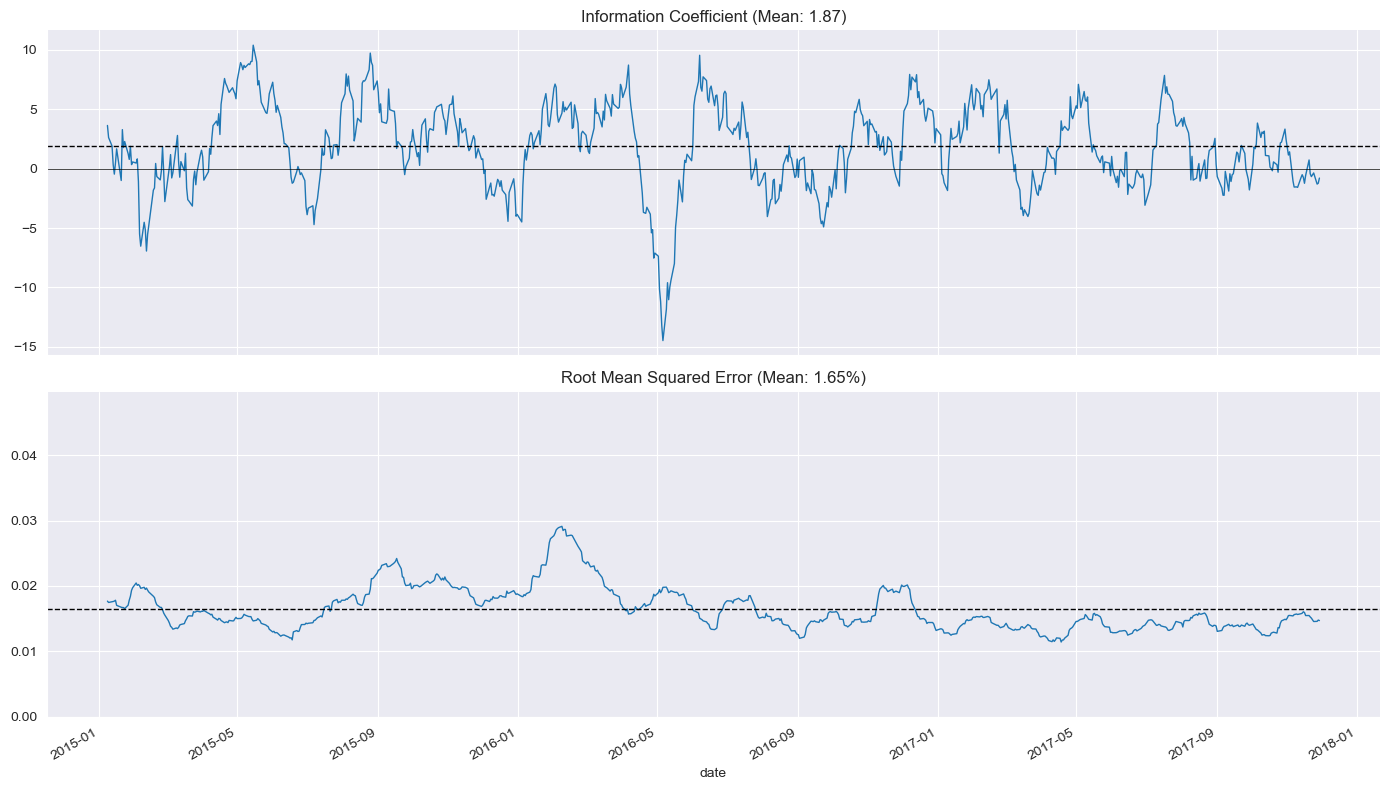

In [24]:
# Rolling Daily IC
plot_rolling_ic(lr_scores)

In [25]:
# Ridge Regression
# Define cross-validation parameters 
# logspace(start, stop, num) Returns numbers spaced evenly on a log scale. 
# In linear space, the sequence starts at base ** start (base to the power of start) and ends with base ** stop
ridge_alphas = np.logspace(-4, 4, 9)
ridge_alphas = sorted(list(ridge_alphas) + list(ridge_alphas * 5))

In [26]:
n_splits = int(3 * YEAR/test_period_length)
train_period_length = 63
test_period_length = 10
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [27]:
# Run cross-validation
target = f'target_{lookahead}d'

X = X.drop([c for c in X.columns if 'year' in c], axis=1)

In [28]:
%%time
ridge_coeffs, ridge_scores, ridge_predictions = {}, [], []

for alpha in ridge_alphas:
    print(alpha, end=' ', flush=True)
    start = time()
    model = Ridge(alpha=alpha,
                  fit_intercept=False,
                  random_state=42)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])

    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]

        pipe.fit(X=X_train, y=y_train)
        y_pred = pipe.predict(X_test)

        preds = y_test.to_frame('actuals').assign(predicted=y_pred)
        preds_by_day = preds.groupby(level='date')
        scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                   x.actuals)[0] * 100)
                            .to_frame('ic'),
                            preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                    y_true=x.actuals)))
                            .to_frame('rmse')], axis=1)

        ridge_scores.append(scores.assign(alpha=alpha))
        ridge_predictions.append(preds.assign(alpha=alpha))

        coeffs.append(pipe.named_steps['model'].coef_)
    ridge_coeffs[alpha] = np.mean(coeffs, axis=0)

print('\n')

0.0001 0.0005 0.001 0.005 0.01 0.05 0.1 0.5 1.0 5.0 10.0 50.0 100.0 500.0 1000.0 5000.0 10000.0 50000.0 

CPU times: user 4min 1s, sys: 9.96 s, total: 4min 11s
Wall time: 1min 6s


In [29]:
# Persist Results
ridge_scores = pd.concat(ridge_scores)
ridge_scores.to_hdf('/Volumes/My Book/Data_Analysis/Data/data.h5', 'ridge/scores')

ridge_coeffs = pd.DataFrame(ridge_coeffs, index=X.columns).T
ridge_coeffs.to_hdf('/Volumes/My Book/Data_Analysis/Data/data.h5', 'ridge/coeffs')

ridge_predictions = pd.concat(ridge_predictions)
ridge_predictions.to_hdf('/Volumes/My Book/Data_Analysis/Data/data.h5', 'ridge/predictions')

In [119]:
# Read Results
ridge_scores = pd.read_hdf('/Volumes/My Book/Data_Analysis/Data/data.h5', 'ridge/scores')
ridge_coeffs = pd.read_hdf('/Volumes/My Book/Data_Analysis/Data/data.h5', 'ridge/coeffs')
ridge_predictions = pd.read_hdf('/Volumes/My Book/Data_Analysis/Data/data.h5', 'ridge/predictions')
print(ridge_predictions)

                    actuals  predicted       alpha
symbol date                                       
AAPL   2017-11-15  0.011947  -0.001151      0.0001
       2017-11-16 -0.005552  -0.000367      0.0001
       2017-11-17 -0.000999  -0.001023      0.0001
       2017-11-20  0.018590  -0.000696      0.0001
       2017-11-21  0.010512  -0.000253      0.0001
...                     ...        ...         ...
XOM    2014-12-18  0.027205  -0.000362  50000.0000
       2014-12-19 -0.003311  -0.000216  50000.0000
       2014-12-22  0.013500  -0.000248  50000.0000
ZTS    2014-12-09 -0.023962   0.000161  50000.0000
       2014-12-10  0.002572   0.000076  50000.0000

[1332540 rows x 3 columns]


In [31]:
# Evaluate Ridge Results
ridge_r, ridge_p = spearmanr(ridge_predictions.actuals, ridge_predictions.predicted)
print(f'Information Coefficient (overall): {ridge_r:.3%} (p-value: {ridge_p:.4%})')

Information Coefficient (overall): 1.402% (p-value: 0.0000%)


In [32]:
ridge_scores.groupby('alpha').ic.describe()

,count,mean,std,min,25%,50%,75%,max
alpha,,,,,,,,
0.0001,750.0,1.871303,18.645129,-54.905380,-10.094204,2.280767,14.007421,54.221398
0.0005,750.0,1.871258,18.645184,-54.905380,-10.094204,2.280767,14.007421,54.221398
0.0010,750.0,1.871258,18.645184,-54.905380,-10.094204,2.280767,14.007421,54.221398
0.0050,750.0,1.871246,18.645093,-54.905380,-10.094204,2.280767,14.007421,54.221398
0.0100,750.0,1.871549,18.645118,-54.905380,-10.094204,2.280767,14.007421,54.221398
0.0500,750.0,1.871918,18.645721,-54.905380,-10.094204,2.280767,14.007421,54.314162
0.1000,750.0,1.871848,18.646215,-54.905380,-10.094204,2.280767,14.007421,54.314162
0.5000,750.0,1.872295,18.648405,-54.905380,-10.057098,2.260359,14.052050,54.416821
1.0000,750.0,1.869790,18.647546,-54.905380,-10.065645,2.224490,14.052050,54.416821


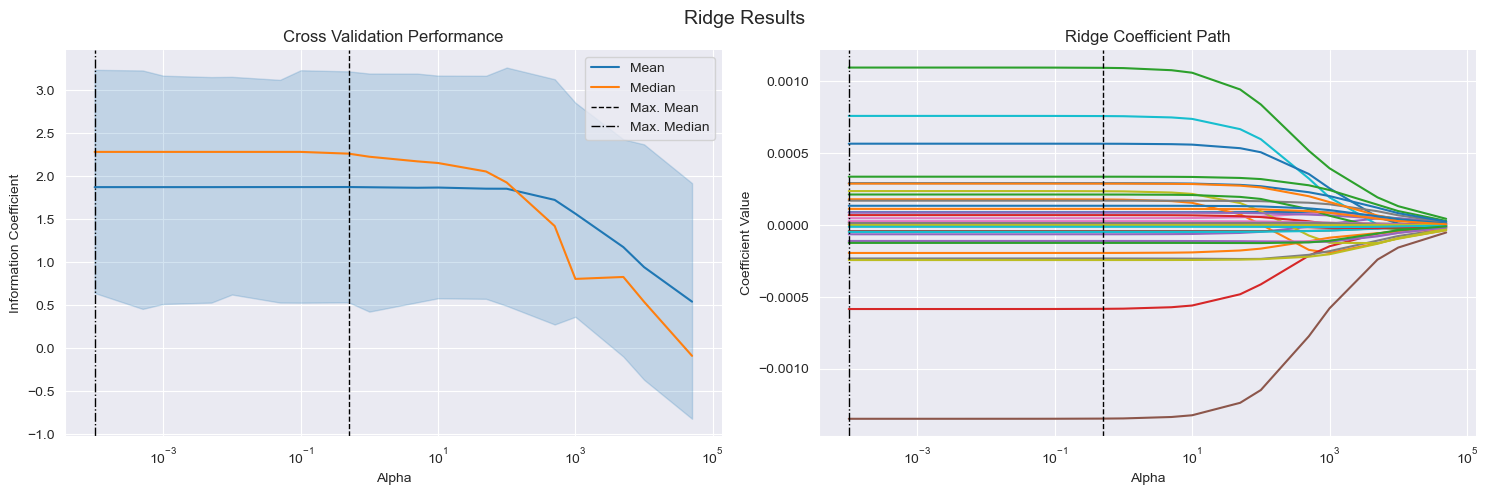

In [33]:
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

scores_by_alpha = ridge_scores.groupby('alpha').ic.agg(['mean', 'median'])
best_alpha_mean = scores_by_alpha['mean'].idxmax()
best_alpha_median = scores_by_alpha['median'].idxmax()

ax = sns.lineplot(x='alpha',
                  y='ic',
                  data=ridge_scores,
                  estimator=np.mean,
                  label='Mean',
                  ax=axes[0])

scores_by_alpha['median'].plot(logx=True,
                               ax=axes[0],
                               label='Median')

axes[0].axvline(best_alpha_mean,
                ls='--',
                c='k',
                lw=1,
                label='Max. Mean')
axes[0].axvline(best_alpha_median,
                ls='-.',
                c='k',
                lw=1,
                label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Information Coefficient')
axes[0].set_title('Cross Validation Performance')

ridge_coeffs.plot(logx=True,
                  legend=False,
                  ax=axes[1],
                  title='Ridge Coefficient Path')

axes[1].axvline(best_alpha_mean,
                ls='--',
                c='k',
                lw=1,
                label='Max. Mean')
axes[1].axvline(best_alpha_median,
                ls='-.',
                c='k',
                lw=1,
                label='Max. Median')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coefficient Value')

fig.suptitle('Ridge Results', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)

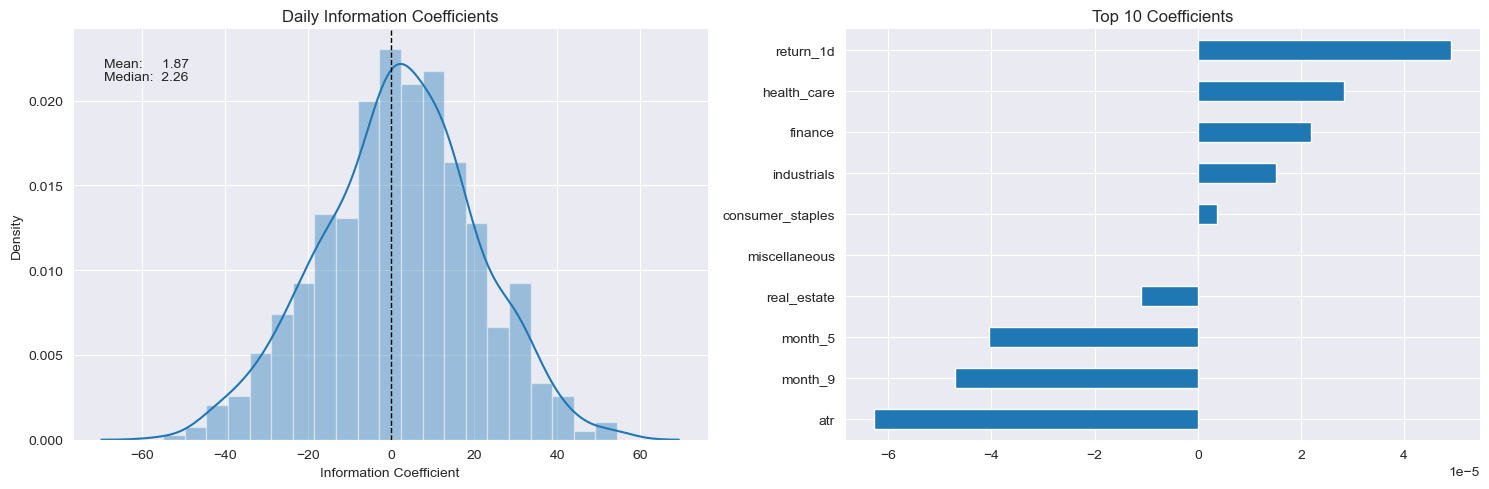

In [34]:
best_alpha = ridge_scores.groupby('alpha').ic.mean().idxmax()
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(ridge_scores[ridge_scores.alpha == best_alpha],
                     ax=axes[0])
axes[0].set_title('Daily Information Coefficients')
top_coeffs = ridge_coeffs.loc[best_alpha].abs().sort_values().head(10).index
top_coeffs.tolist()
ridge_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1],
                                                                 title='Top 10 Coefficients')
sns.despine()
fig.tight_layout()

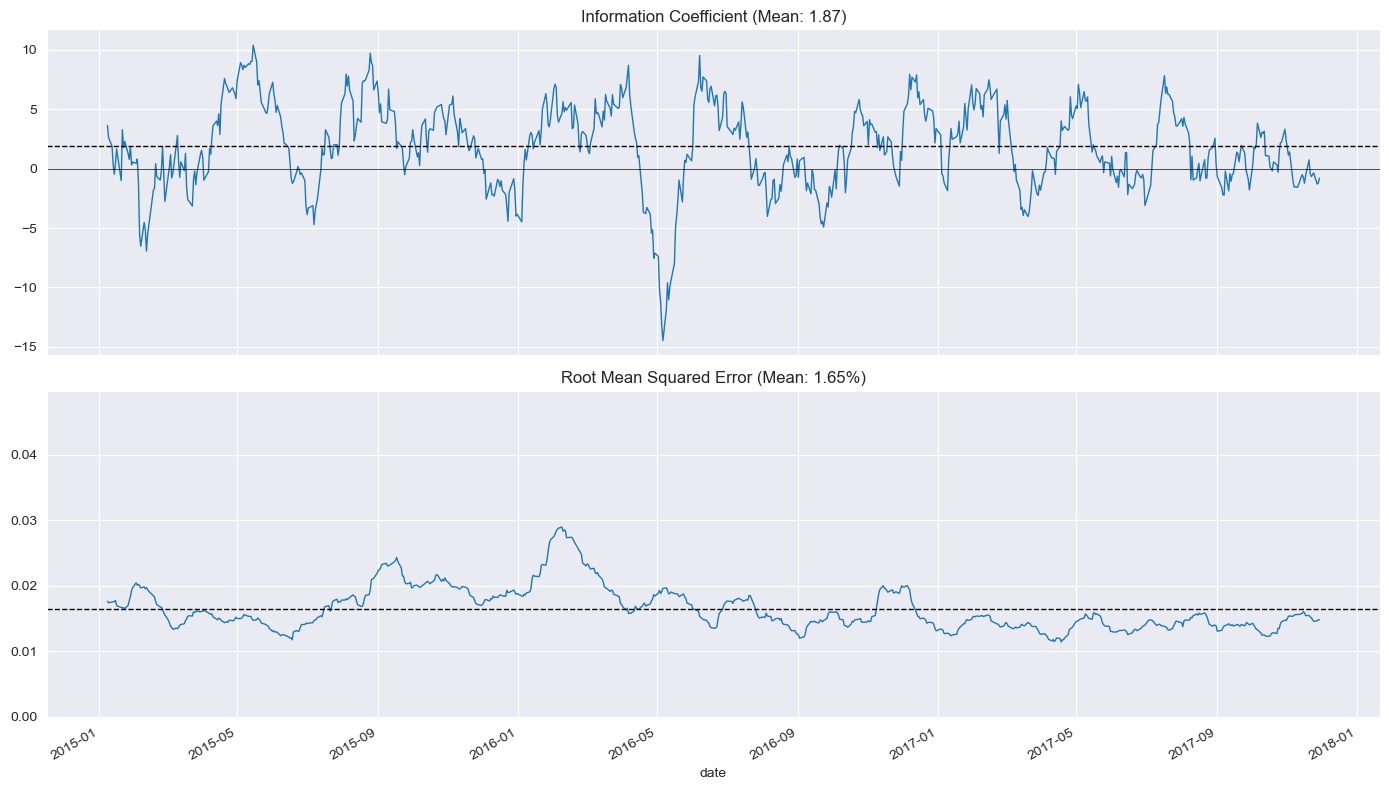

In [35]:
plot_rolling_ic(ridge_scores[ridge_scores.alpha==best_alpha])

In [36]:
# Lasso CV
# Define cross-validation parameters
lasso_alphas = np.logspace(-10, -3, 8)

In [37]:
train_period_length = 63
test_period_length = 10
YEAR = 252
n_splits = int(3 * YEAR / test_period_length) # three years
lookahead = 1

In [38]:
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [39]:
# Run cross-validation with Lasso regression
target = f'target_{lookahead}d'

scaler = StandardScaler()
X = X.drop([c for c in X.columns if 'year' in c], axis=1)

In [40]:
%%time

lasso_coeffs, lasso_scores, lasso_predictions = {}, [], []
for alpha in lasso_alphas:
    print(alpha, end=' ', flush=True)
    model = Lasso(alpha=alpha,
                  fit_intercept=False,  # StandardScaler centers data
                  random_state=42,
                  tol=1e-3,
                  max_iter=1000,
                  warm_start=True,
                  selection='random')

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])
    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        t = time()
        X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]

        pipe.fit(X=X_train, y=y_train)
        y_pred = pipe.predict(X_test)

        preds = y_test.to_frame('actuals').assign(predicted=y_pred)
        preds_by_day = preds.groupby(level='date')
        scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                   x.actuals)[0] * 100)
                            .to_frame('ic'),
                            preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                    y_true=x.actuals)))
                            .to_frame('rmse')],
                           axis=1)

        lasso_scores.append(scores.assign(alpha=alpha))
        lasso_predictions.append(preds.assign(alpha=alpha))

        coeffs.append(pipe.named_steps['model'].coef_)

    lasso_coeffs[alpha] = np.mean(coeffs, axis=0)

1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 0.0001 0.001 CPU times: user 4min 27s, sys: 5.41 s, total: 4min 33s
Wall time: 1min 10s


In [41]:
# Persist Results
lasso_scores = pd.concat(lasso_scores)
lasso_scores.to_hdf('/Volumes/My Book/Data_Analysis/Data/data.h5', 'lasso/scores')

lasso_coeffs = pd.DataFrame(lasso_coeffs, index=X.columns).T
lasso_coeffs.to_hdf('/Volumes/My Book/Data_Analysis/Data/data.h5', 'lasso/coeffs')

lasso_predictions = pd.concat(lasso_predictions)
lasso_predictions.to_hdf('/Volumes/My Book/Data_Analysis/Data/data.h5', 'lasso/predictions')

In [42]:
# Evaluate Lasso Results
best_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()
preds = lasso_predictions[lasso_predictions.alpha==best_alpha]

lasso_r, lasso_p = spearmanr(preds.actuals, preds.predicted)
print(f'Information Coefficient (overall): {lasso_r:.3%} (p-value: {lasso_p:.4%})')

Information Coefficient (overall): 3.525% (p-value: 0.0000%)


In [43]:
lasso_scores.groupby('alpha').ic.agg(['mean', 'median'])

,mean,median
alpha,,
1.000000e-10,1.871310,2.280767
1.000000e-09,1.871331,2.280767
1.000000e-08,1.871237,2.280767
1.000000e-07,1.871075,2.260359
1.000000e-06,1.866013,2.207792
1.000000e-05,1.878241,2.076379
1.000000e-04,1.426132,1.092768
1.000000e-03,0.371738,0.076685


             ic      rmse         alpha
0      0.454577  0.019873  1.000000e-10
1    -27.794767  0.012151  1.000000e-10
2     21.251650  0.010363  1.000000e-10
3     27.602981  0.013356  1.000000e-10
4    -17.801197  0.008901  1.000000e-10
...         ...       ...           ...
5995 -46.187412  0.032961  1.000000e-03
5996  21.743737  0.029403  1.000000e-03
5997 -59.139215  0.020913  1.000000e-03
5998  49.392023  0.019736  1.000000e-03
5999 -33.834004  0.015425  1.000000e-03

[6000 rows x 3 columns]


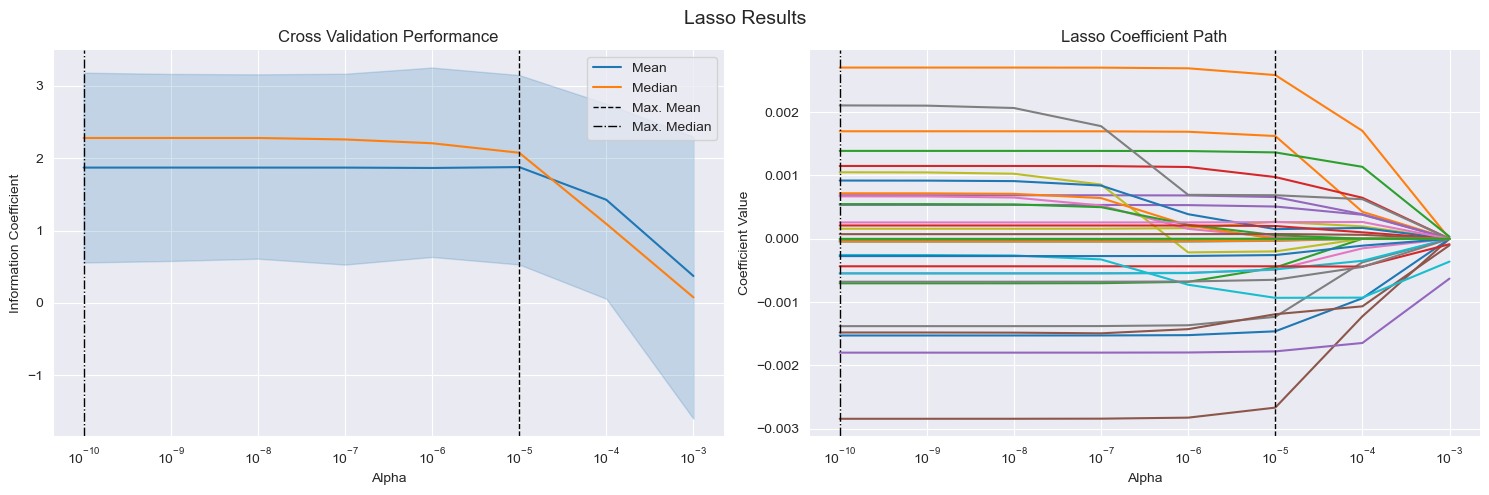

In [45]:
############################################
# The below line had to be applied to resolve the issue where seaborn sns does not take duplicate index
lasso_scores.reset_index(drop = True, inplace = True)
############################################
print(lasso_scores)
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

scores_by_alpha = lasso_scores.groupby('alpha').ic.agg(['mean', 'median'])
best_alpha_mean = scores_by_alpha['mean'].idxmax()
best_alpha_median = scores_by_alpha['median'].idxmax()

ax = sns.lineplot(x='alpha', y='ic', data=lasso_scores, estimator=np.mean, label='Mean', ax=axes[0])

scores_by_alpha['median'].plot(logx=True, ax=axes[0], label='Median')

axes[0].axvline(best_alpha_mean, ls='--', c='k', lw=1, label='Max. Mean')
axes[0].axvline(best_alpha_median, ls='-.', c='k', lw=1, label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Information Coefficient')
axes[0].set_title('Cross Validation Performance')

lasso_coeffs.plot(logx=True, legend=False, ax=axes[1], title='Lasso Coefficient Path')
axes[1].axvline(best_alpha_mean, ls='--', c='k', lw=1, label='Max. Mean')
axes[1].axvline(best_alpha_median, ls='-.', c='k', lw=1, label='Max. Median')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coefficient Value')

fig.suptitle('Lasso Results', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.9)
sns.despine();

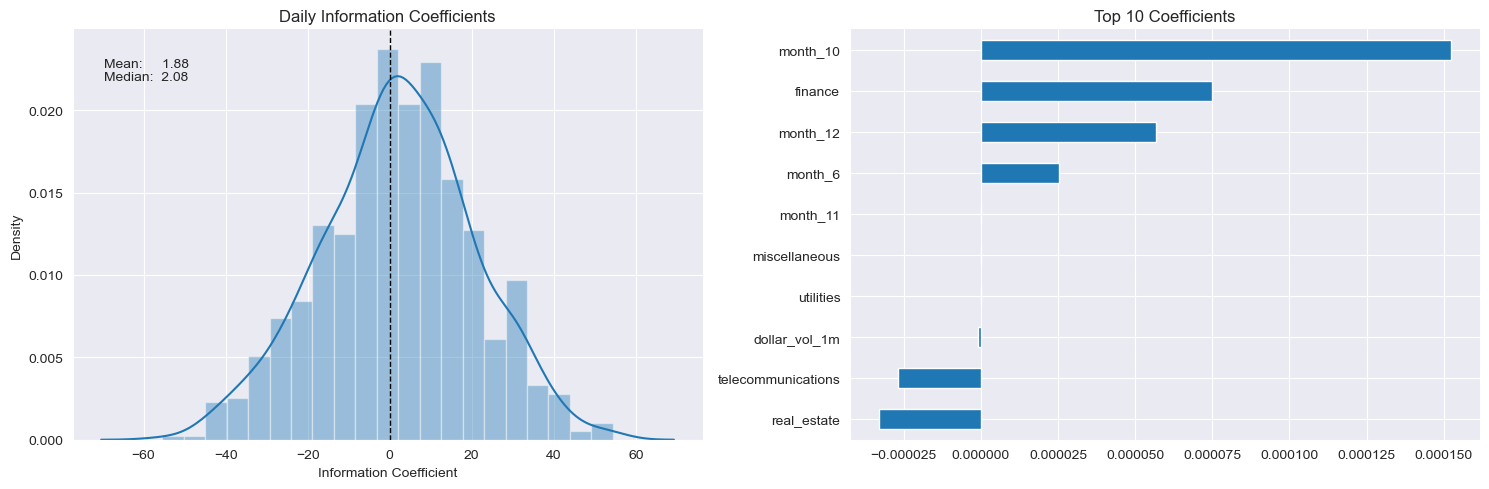

In [46]:
# Lasso IC Distribution and Top 10 Features
best_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(lasso_scores[lasso_scores.alpha==best_alpha], ax=axes[0])
axes[0].set_title('Daily Information Coefficients')

top_coeffs = lasso_coeffs.loc[best_alpha].abs().sort_values().head(10).index
top_coeffs.tolist()
lasso_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1], title='Top 10 Coefficients')

sns.despine()
fig.tight_layout();

In [47]:
# Compare results
best_ridge_alpha = ridge_scores.groupby('alpha').ic.mean().idxmax()
best_ridge_preds = ridge_predictions[ridge_predictions.alpha==best_ridge_alpha]
best_ridge_scores = ridge_scores[ridge_scores.alpha==best_ridge_alpha]

In [48]:
best_lasso_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()
best_lasso_preds = lasso_predictions[lasso_predictions.alpha==best_lasso_alpha]
best_lasso_scores = lasso_scores[lasso_scores.alpha==best_lasso_alpha]

In [49]:
df = pd.concat([lr_scores.assign(Model='Linear Regression'),
               best_ridge_scores.assign(Model='Ridge Regression'),
               best_lasso_scores.assign(Model='Lasso Regression')]).drop('alpha', axis=1)
df.columns = ['IC', 'RMSE', 'Model']

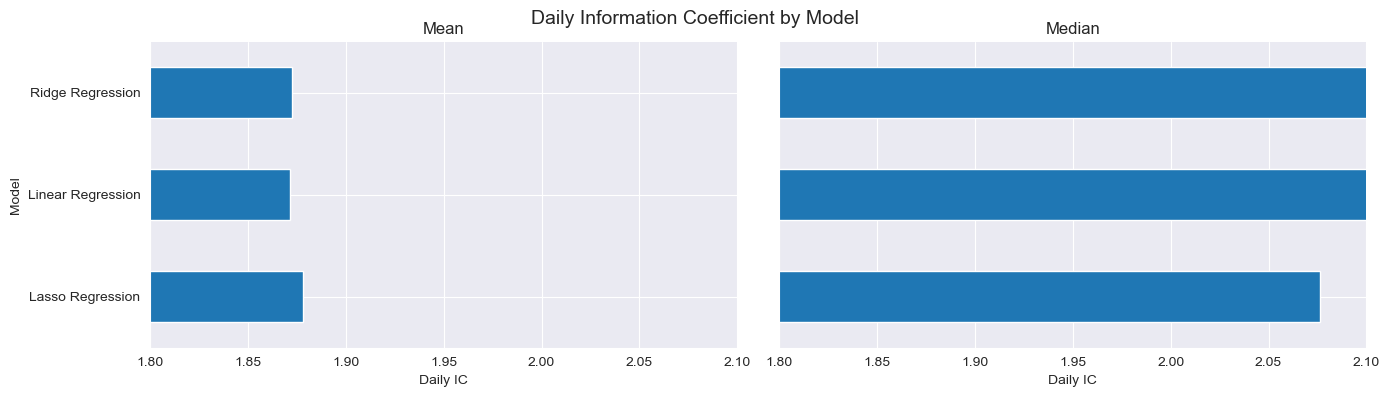

In [50]:
scores = df.groupby('Model').IC.agg(['mean', 'median'])
fig, axes = plt.subplots(ncols=2, figsize=(14,4), sharey=True, sharex=True)

scores['mean'].plot.barh(ax=axes[0], xlim=(1.85, 2), title='Mean')
scores['median'].plot.barh(ax=axes[1], xlim=(1.8, 2.1), title='Median')
axes[0].set_xlabel('Daily IC')
axes[1].set_xlabel('Daily IC')

fig.suptitle('Daily Information Coefficient by Model', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)